In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
# from skimage.util import montage2d as montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight
%matplotlib inline

# montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
# ship_dir = '../input'
# train_image_dir = os.path.join(ship_dir, 'train')

In [3]:
import glob

test_img_dir = 'data/test_img'
inputDF = pd.read_csv('data/train_ship_segmentations_v2.csv')

image_names = [f for f in os.listdir(test_img_dir)]

test_DF = inputDF.loc[inputDF['ImageId'].isin(image_names)]

test_DF.head()

,ImageId,EncodedPixels
217189,f000067f0.jpg,NaN
217190,f00087dcd.jpg,NaN
217191,f000c1a04.jpg,NaN
217192,f00189b8c.jpg,NaN
217193,f001dfbd1.jpg,NaN


In [4]:
test_DF.info(())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14534 entries, 217189 to 231722
Data columns (total 2 columns):
ImageId          14534 non-null object
EncodedPixels    5150 non-null object
dtypes: object(2)
memory usage: 340.6+ KB


,ImageId,ships,has_ship,has_ship_vec,file_size_kb
10788,fe4738117.jpg,0,0.0,[0.0],108.576172
4219,f591672fb.jpg,0,0.0,[0.0],316.840820
5733,f799e2317.jpg,0,0.0,[0.0],163.268555
2964,f3f067a75.jpg,0,0.0,[0.0],90.027344
4732,f644ff3fa.jpg,0,0.0,[0.0],120.405273
270,f057a7f67.jpg,1,1.0,[1.0],136.177734
2668,f381626e0.jpg,0,0.0,[0.0],171.638672


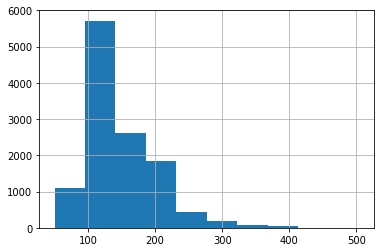

In [8]:
masks = test_DF.copy()
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(test_img_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

In [15]:
############################## Hyperparameters ######################################

BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 9
MAX_TRAIN_EPOCHS = 99
AUGMENT_BRIGHTNESS = False


############################## Utility Functions ######################################

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

############################## END ######################################

############################## Generator to produce input ######################################

def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(test_img_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

                



In [16]:
VALID_IMG_COUNT = 900

test_x, test_y = next(make_image_gen(test_DF, VALID_IMG_COUNT))

In [17]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

## intersection over union
def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return -K.mean( (intersection + eps) / (union + eps), axis=0)

## Model 1 -- training batch = 48

In [9]:
# load json and create model
from keras.models import model_from_json

batch_48_json_file = open('output/test1_batch_48/model.json', 'r')
batch_48_loaded_model_json = batch_48_json_file.read()
# loaded_model_json
batch_48_json_file.close()

batch_48_loaded_model = model_from_json(batch_48_loaded_model_json)
# load weights into new model
batch_48_loaded_model.load_weights("output/test1_batch_48/seg_model.h5")
print("Loaded model from disk")



Using TensorFlow backend.


Loaded model from disk


In [10]:
import pickle

with open('output/test1_batch_48/epochs.p', 'rb') as fp:
    epochs = pickle.load(fp)
    
with open('output/test1_batch_48/loss_loss.p', 'rb') as fp:
    loss_loss = pickle.load(fp)

with open('output/test1_batch_48/val_loss.p', 'rb') as fp:
    val_loss = pickle.load(fp)

with open('output/test1_batch_48/bi_acc.p', 'rb') as fp:
    bi_acc = pickle.load(fp)

with open('output/test1_batch_48/val_bi_acc.p', 'rb') as fp:
    val_bi_acc = pickle.load(fp)
    


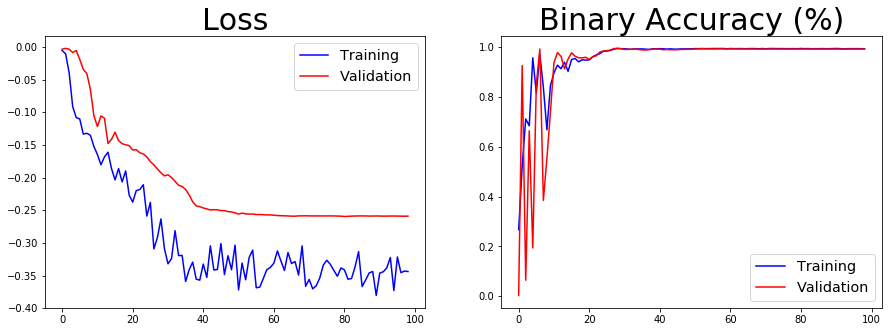

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(epochs, loss_loss, 'b-',epochs, val_loss, 'r-')
ax1.legend(['Training', 'Validation'], fontsize = 'x-large')
ax1.set_title('Loss', fontsize=30)
ax2.plot(epochs, bi_acc, 'b-', epochs, val_bi_acc, 'r-')
ax2.legend(['Training', 'Validation'], fontsize = 'x-large')
ax2.set_title('Binary Accuracy (%)', fontsize=30)
fig.savefig('loss_history')
plt.show()

### Test Image IoU

In [18]:
batch_48_loaded_model.compile(optimizer=Adam(1e-3, decay=1e-6),
                              loss=IoU,
                              metrics=['binary_accuracy'])


pred_y = batch_48_loaded_model.predict(test_x)

pred_y_int = pred_y.astype(np.uint8)

eps=1e-6

inter = np.sum(test_y[4] * pred_y_int[4])
uni = np.sum(test_y[4]) + np.sum(pred_y_int[4]) - inter

IoU_test = (inter + eps) / (uni+eps)
print('The IoU of test image is: {}'.format(IoU_test))

The IoU of test image is: 1.0


In [20]:
score = batch_48_loaded_model.evaluate(test_x, test_y)

print('IoU loss is: {}'.format(score[0]))
print('Binary accuracy is: {}'.format(score[1]))


900/900 [==============================] - 397s 441ms/step
IoU loss is: -0.5358912634849549
Binary accuracy is: 0.997018551296658


## Model 2 -- training batch = 128

In [21]:
batch_128_json_file = open('output/test2_batch_128/model.json', 'r')
batch_128_loaded_model_json = batch_128_json_file.read()
# loaded_model_json
batch_128_json_file.close()

batch_128_loaded_model = model_from_json(batch_128_loaded_model_json)
# load weights into new model
batch_128_loaded_model.load_weights("output/test2_batch_128/seg_model.h5")
print("Loaded model from disk")


Loaded model from disk


In [22]:
with open('output/test2_batch_128/epochs.p', 'rb') as fp:
    epochs = pickle.load(fp)
    
with open('output/test2_batch_128/loss_loss.p', 'rb') as fp:
    loss_loss = pickle.load(fp)

with open('output/test2_batch_128/val_loss.p', 'rb') as fp:
    val_loss = pickle.load(fp)

with open('output/test2_batch_128/bi_acc.p', 'rb') as fp:
    bi_acc = pickle.load(fp)

with open('output/test2_batch_128/val_bi_acc.p', 'rb') as fp:
    val_bi_acc = pickle.load(fp)
    

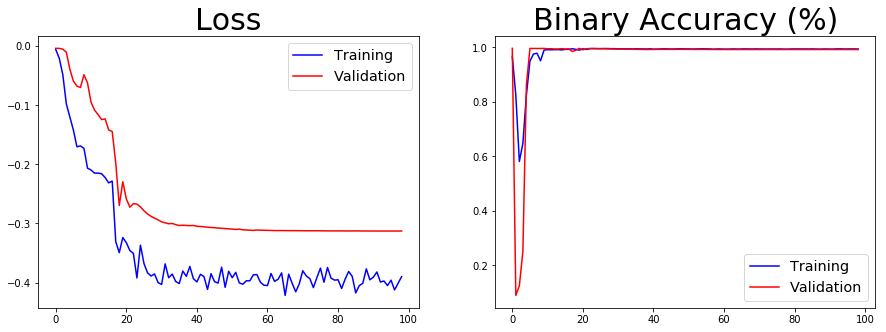

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(epochs, loss_loss, 'b-',epochs, val_loss, 'r-')
ax1.legend(['Training', 'Validation'], fontsize = 'x-large')
ax1.set_title('Loss', fontsize=30)
ax2.plot(epochs, bi_acc, 'b-', epochs, val_bi_acc, 'r-')
ax2.legend(['Training', 'Validation'], fontsize = 'x-large')
ax2.set_title('Binary Accuracy (%)', fontsize=30)
fig.savefig('loss_history')
plt.show()

In [26]:
batch_128_loaded_model.compile(optimizer=Adam(1e-3, decay=1e-6),
                              loss=IoU,
                              metrics=['binary_accuracy'])

score_128 = batch_128_loaded_model.evaluate(test_x, test_y)



900/900 [==============================] - 406s 451ms/step
IoU loss is: -0.5358912634849549
Binary accuracy is: 0.997018551296658


In [27]:
print('IoU loss is: {}'.format(score_128[0]))
print('Binary accuracy is: {}'.format(score_128[1]))

IoU loss is: -0.6699580181969537
Binary accuracy is: 0.9974964057074652


## Model 3 -- training batch = 96

In [66]:
batch_96_json_file = open('output/test3_batch_96/model.json', 'r')
batch_96_loaded_model_json = batch_96_json_file.read()
# loaded_model_json
batch_96_json_file.close()

batch_96_loaded_model = model_from_json(batch_96_loaded_model_json)
# load weights into new model
batch_96_loaded_model.load_weights("output/test3_batch_96/seg_model.h5")
print("Loaded model from disk")


Loaded model from disk


In [69]:
with open('output/test3_batch_96/epochs.p', 'rb') as fp:
    epochs = pickle.load(fp)
    
with open('output/test3_batch_96/loss_loss.p', 'rb') as fp:
    loss_loss = pickle.load(fp)

with open('output/test3_batch_96/val_loss.p', 'rb') as fp:
    val_loss = pickle.load(fp)

with open('output/test3_batch_96/bi_acc.p', 'rb') as fp:
    bi_acc = pickle.load(fp)

with open('output/test3_batch_96/val_bi_acc.p', 'rb') as fp:
    val_bi_acc = pickle.load(fp)

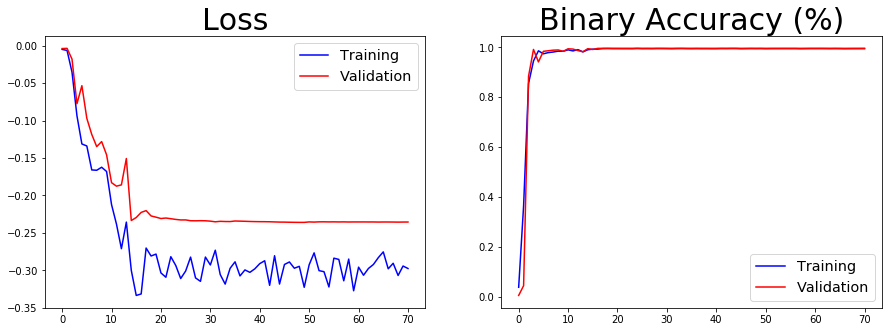

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(epochs, loss_loss, 'b-',epochs, val_loss, 'r-')
ax1.legend(['Training', 'Validation'], fontsize = 'x-large')
ax1.set_title('Loss', fontsize=30)
ax2.plot(epochs, bi_acc, 'b-', epochs, val_bi_acc, 'r-')
ax2.legend(['Training', 'Validation'], fontsize = 'x-large')
ax2.set_title('Binary Accuracy (%)', fontsize=30)
fig.savefig('loss_history')
plt.show()

In [71]:
batch_96_loaded_model.compile(optimizer=Adam(1e-3, decay=1e-6),
                              loss=IoU,
                              metrics=['binary_accuracy'])

score_96 = batch_96_loaded_model.evaluate(test_x, test_y)



900/900 [==============================] - 314s 349ms/step


In [72]:
print('IoU loss is: {}'.format(score_96[0]))
print('Binary accuracy is: {}'.format(score_96[1]))

IoU loss is: -0.7002369329664442
Binary accuracy is: 0.9986965433756511


## Box segment

In [73]:
pred_y_128 = batch_128_loaded_model.predict(test_x)

pred_y_int_128 = pred_y_128.astype(np.uint8)

In [74]:
pred_y_96 = batch_96_loaded_model.predict(test_x)

pred_y_int_96 = pred_y_96.astype(np.uint8)

In [75]:
pred_y_48 = pred_y
pred_y_48_int = pred_y_int

In [76]:
non_empty_idx = []
for i in range(len(test_y)):
    if np.sum(test_y[i]) != 0:
        non_empty_idx.append(i)

In [77]:
print(non_empty_idx)

[0, 1, 2, 7, 8, 11, 12, 20, 22, 23, 27, 31, 37, 43, 51, 54, 58, 61, 65, 67, 69, 77, 78, 80, 83, 84, 90, 91, 93, 107, 109, 110, 112, 120, 123, 127, 132, 136, 139, 150, 152, 155, 159, 160, 164, 165, 169, 173, 176, 180, 182, 184, 196, 199, 201, 218, 223, 224, 228, 231, 237, 239, 241, 243, 244, 248, 254, 255, 256, 257, 269, 284, 285, 286, 288, 289, 292, 297, 299, 303, 305, 318, 319, 320, 321, 330, 336, 337, 338, 340, 345, 347, 349, 354, 362, 383, 387, 396, 402, 413, 416, 426, 429, 431, 435, 437, 438, 439, 442, 444, 446, 449, 456, 465, 472, 474, 480, 486, 489, 498, 499, 501, 506, 513, 517, 523, 524, 536, 546, 547, 551, 557, 558, 560, 561, 562, 564, 567, 569, 586, 596, 603, 605, 608, 610, 611, 616, 618, 622, 625, 626, 627, 628, 633, 646, 658, 664, 667, 684, 686, 689, 692, 693, 697, 705, 715, 719, 723, 725, 726, 734, 738, 747, 751, 753, 755, 762, 770, 773, 775, 781, 782, 786, 789, 806, 812, 820, 823, 833, 839, 842, 850, 852, 856, 860, 869, 870, 871, 884, 886, 889, 893, 895, 896, 899]


0


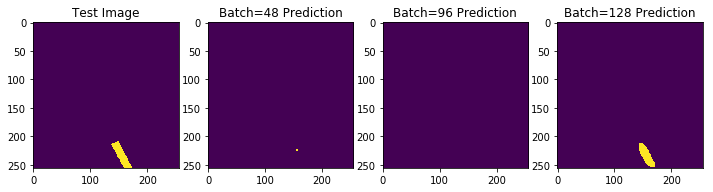

1


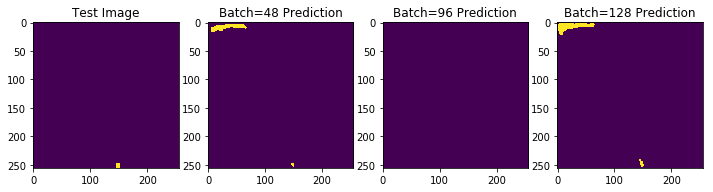

2


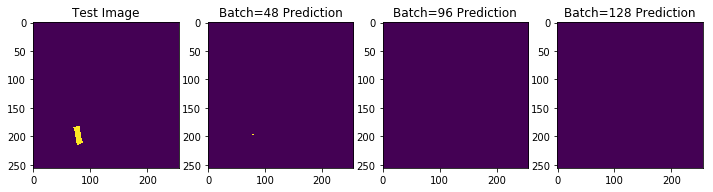

7


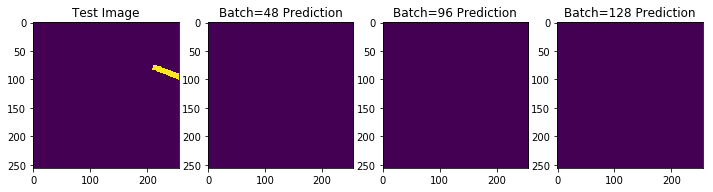

8


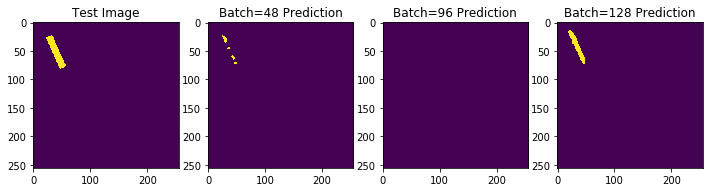

11


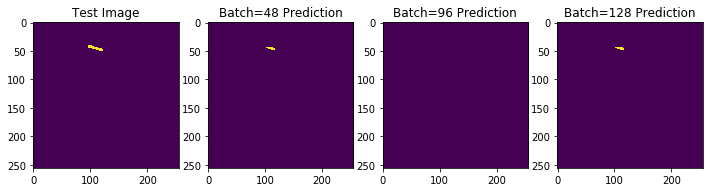

12


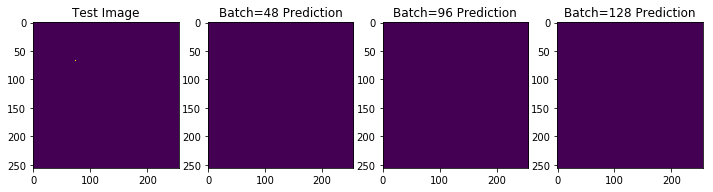

20


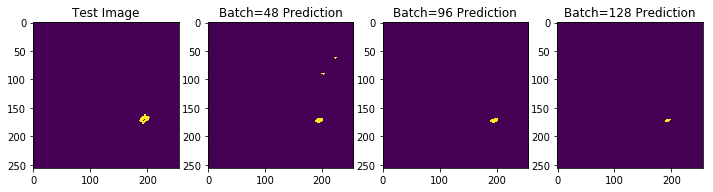

22


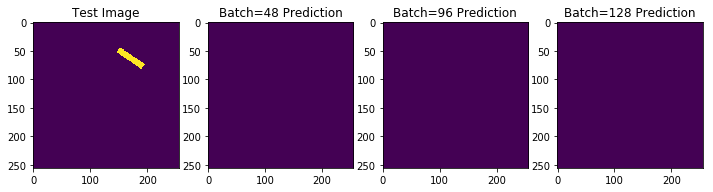

23


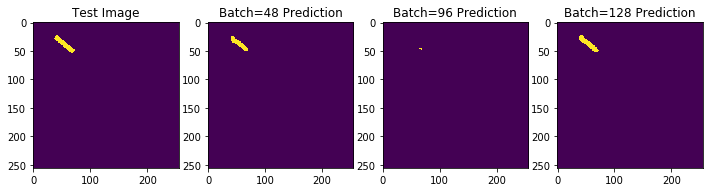

27


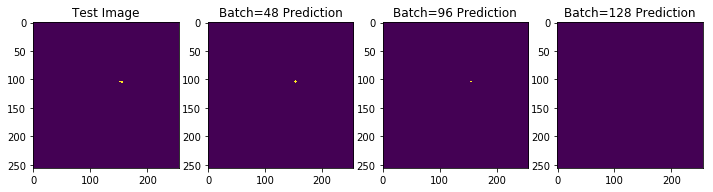

31


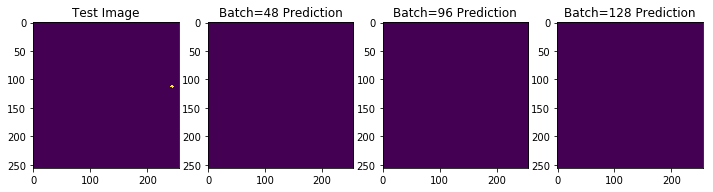

37


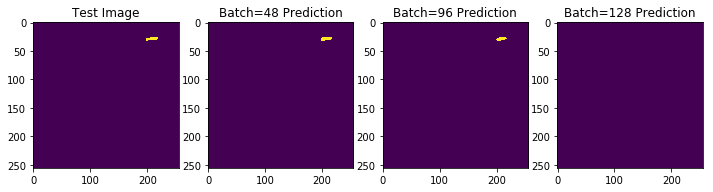

43


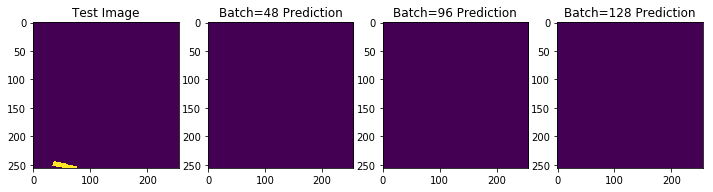

51


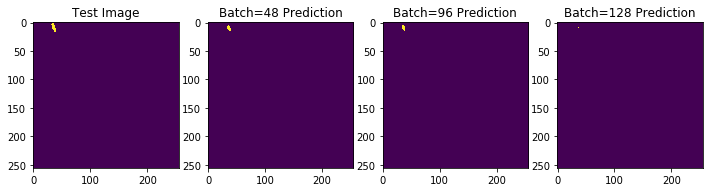

54


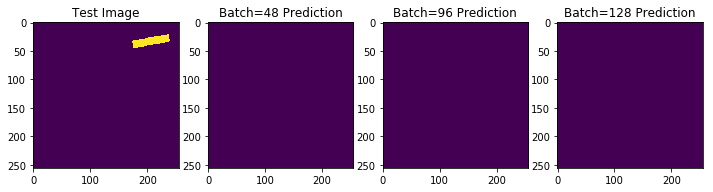

58


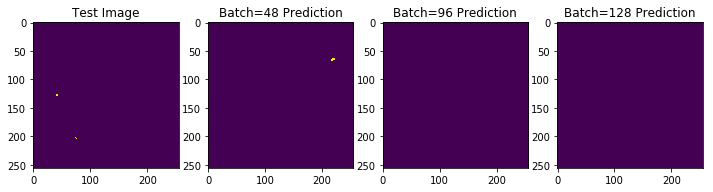

61


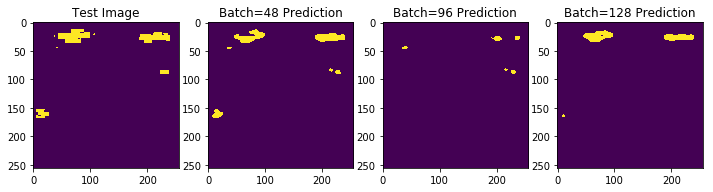

65


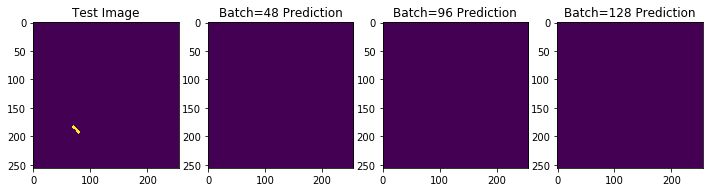

67


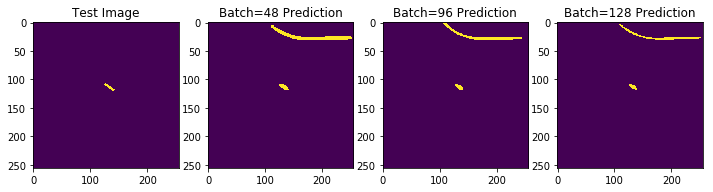

69


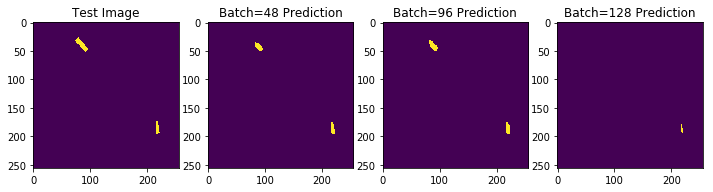

77


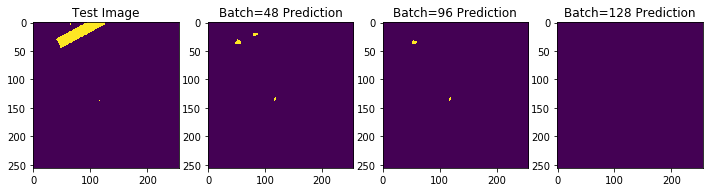

78


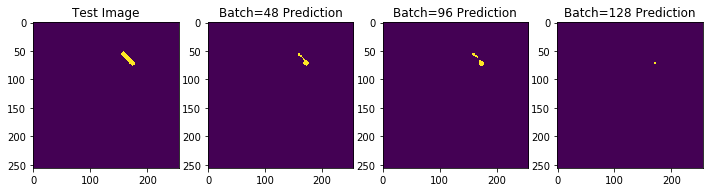

80


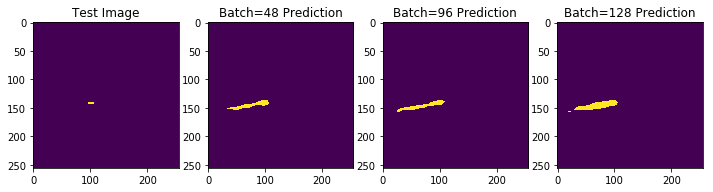

83


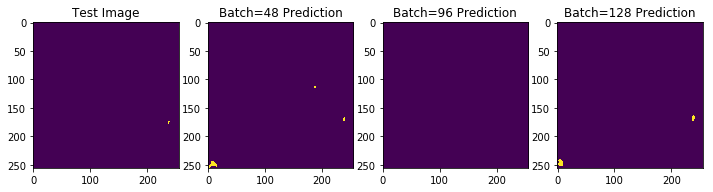

84


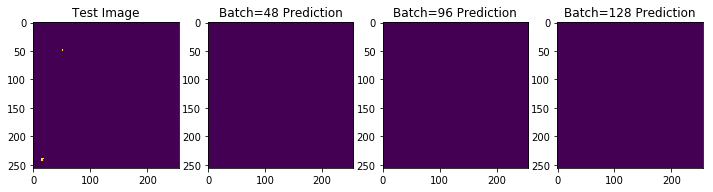

90


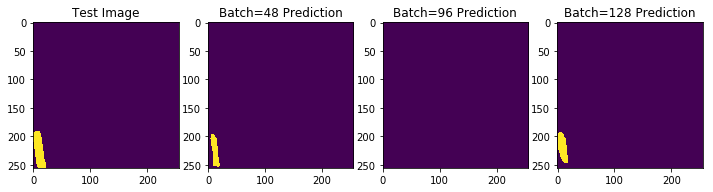

91


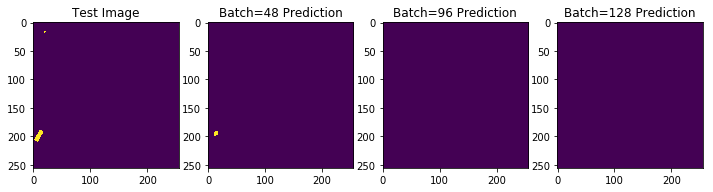

93


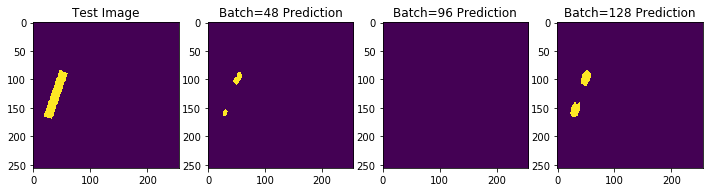

107


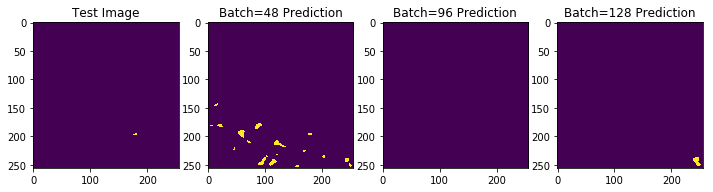

109


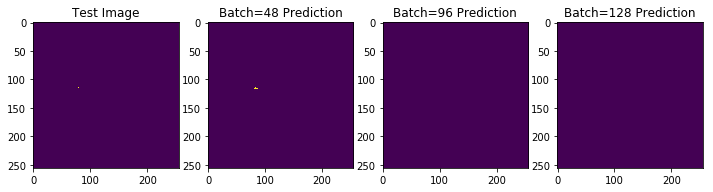

110


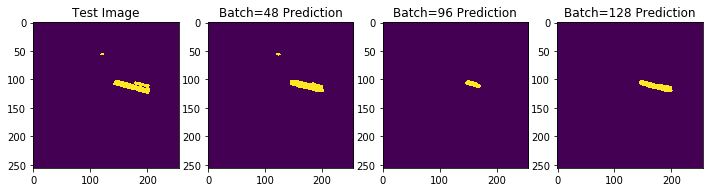

112


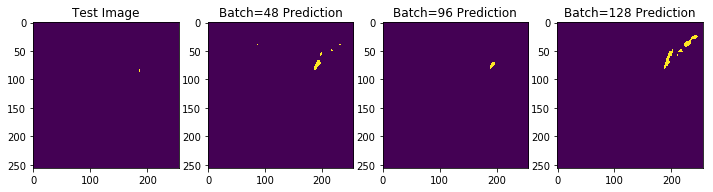

120


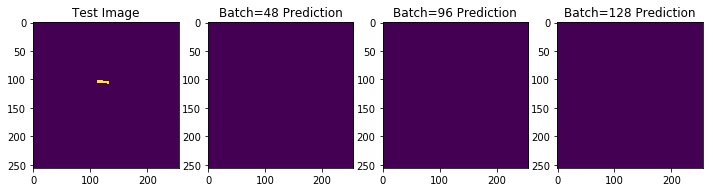

123


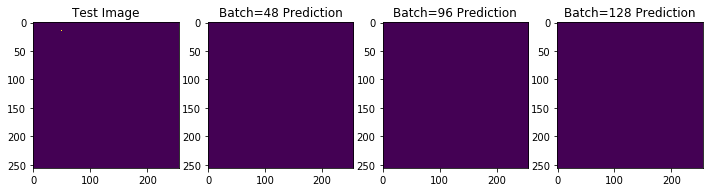

127


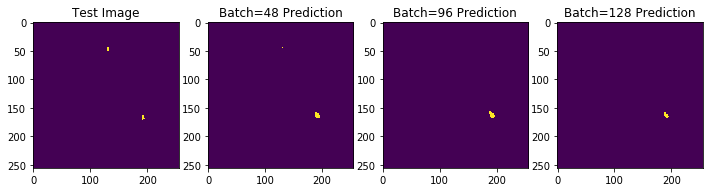

132


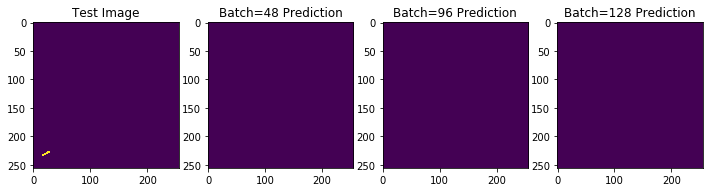

136


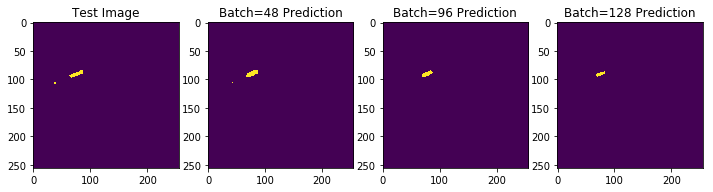

139


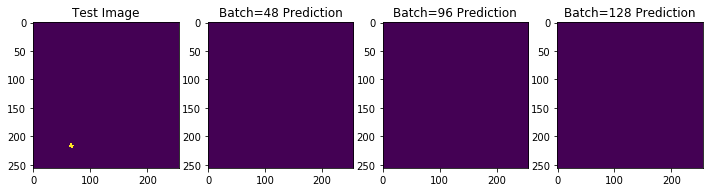

150


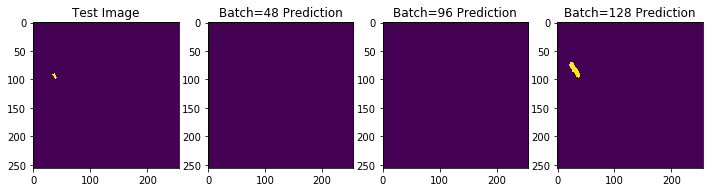

152


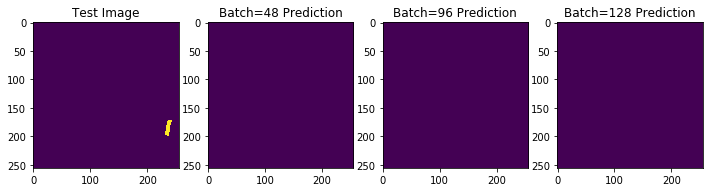

155


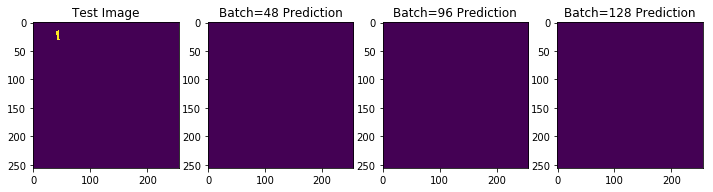

159


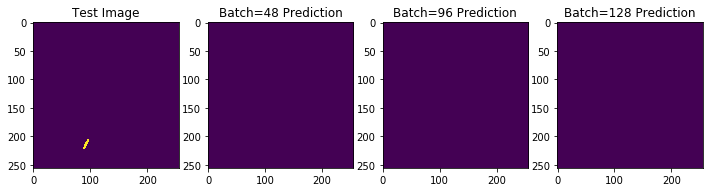

160


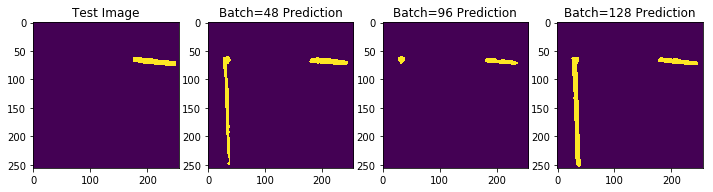

164


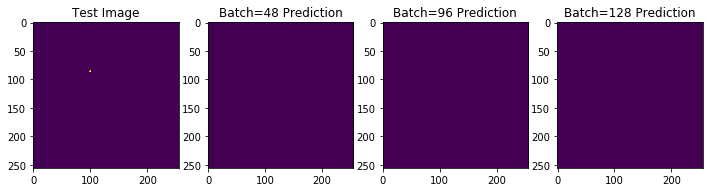

165


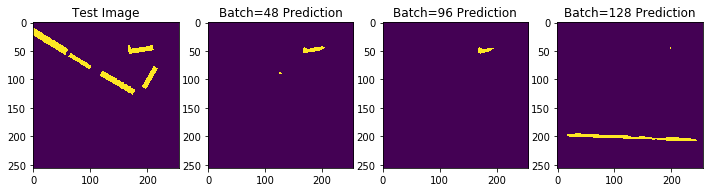

169


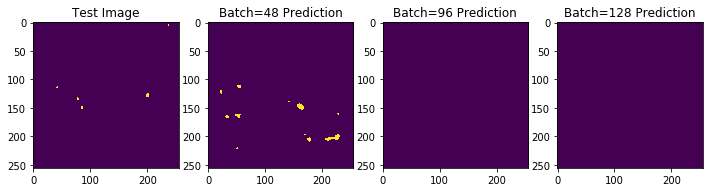

173


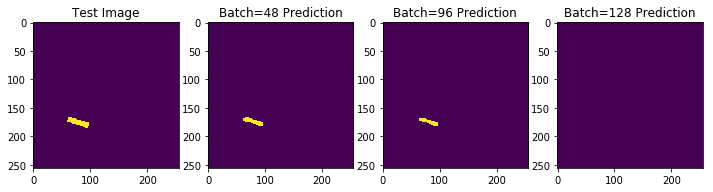

176


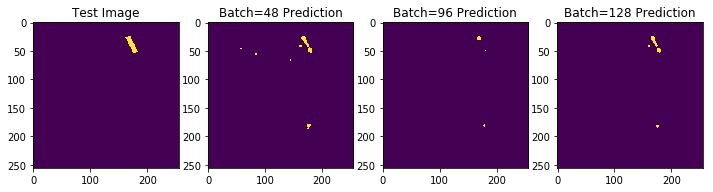

180


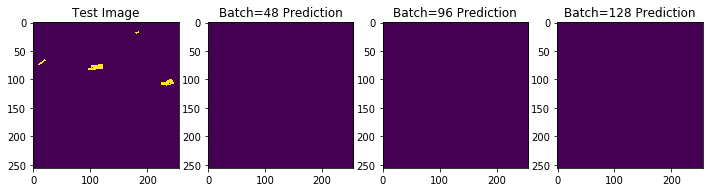

182


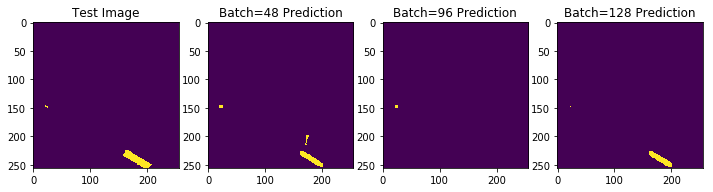

184


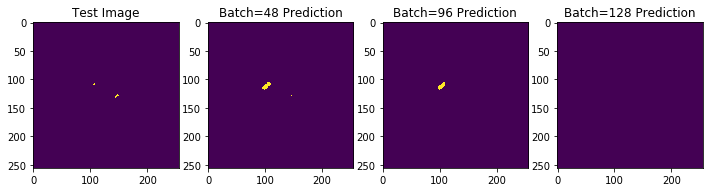

196


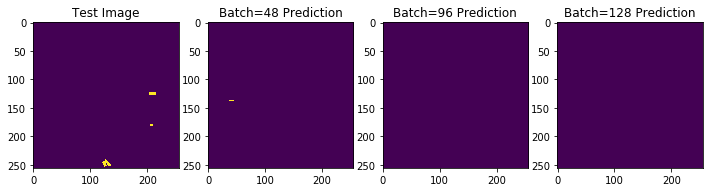

199


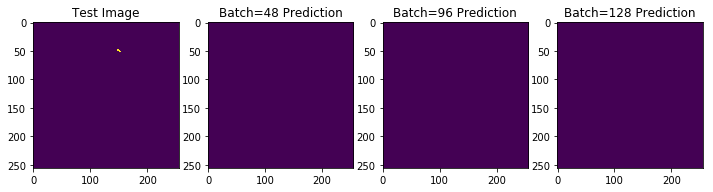

201


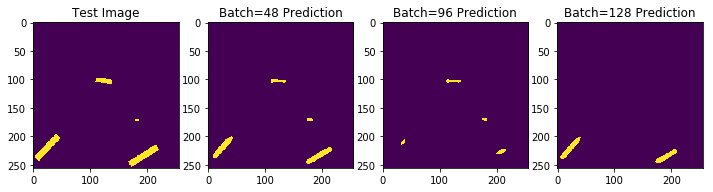

218


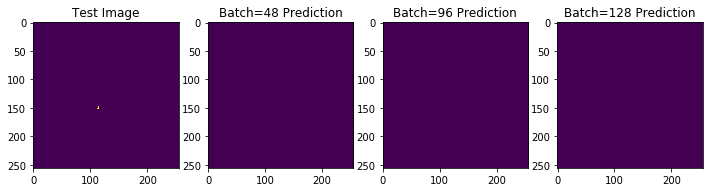

223


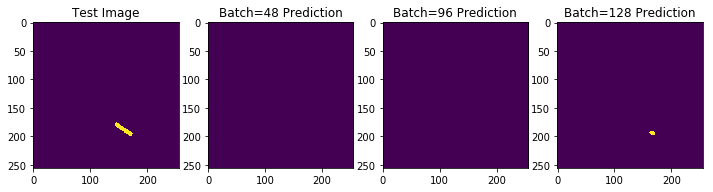

224


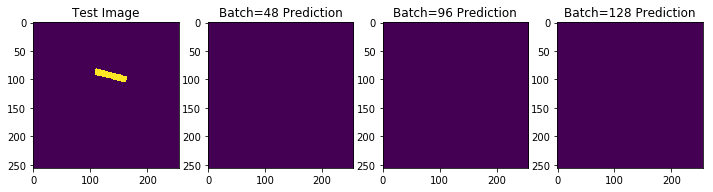

228


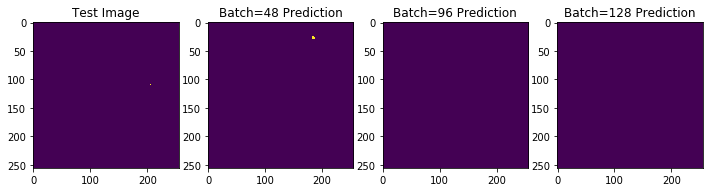

231


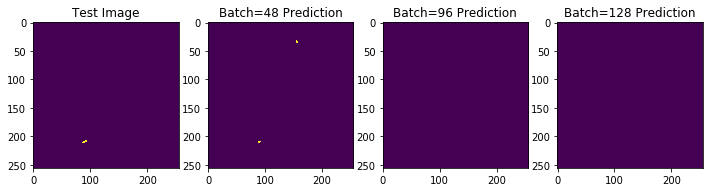

237


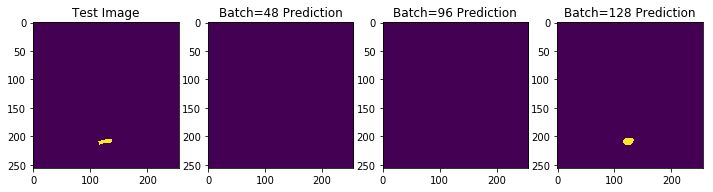

239


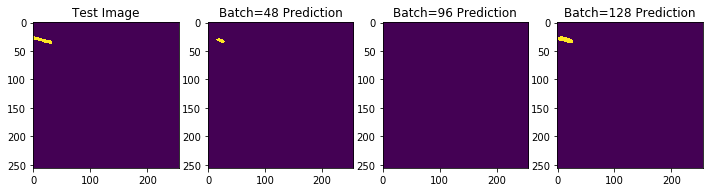

241


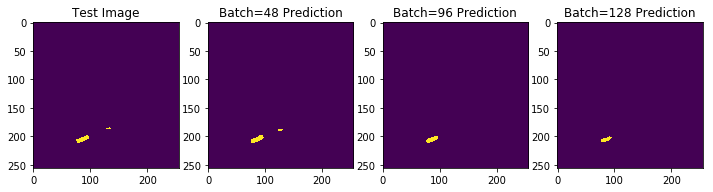

243


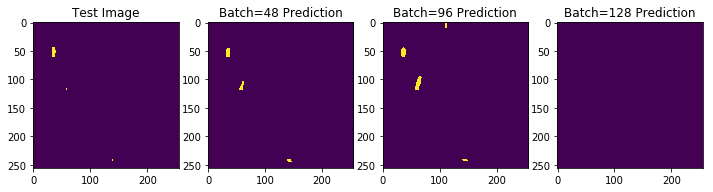

244


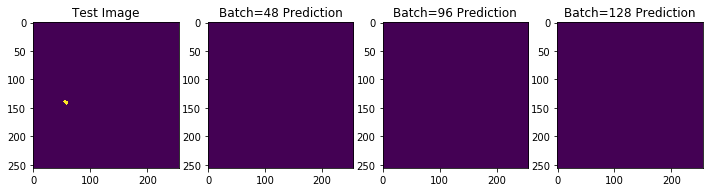

248


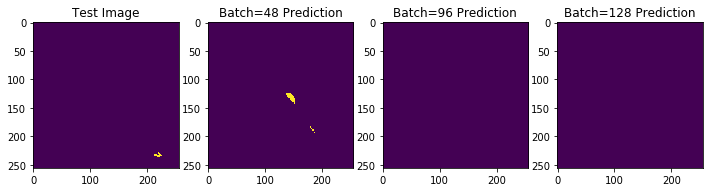

254


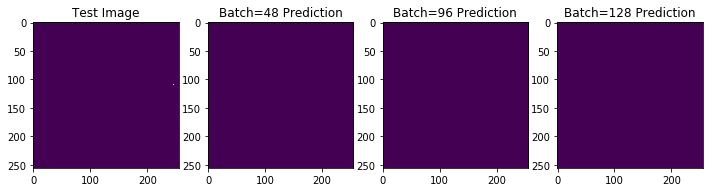

255


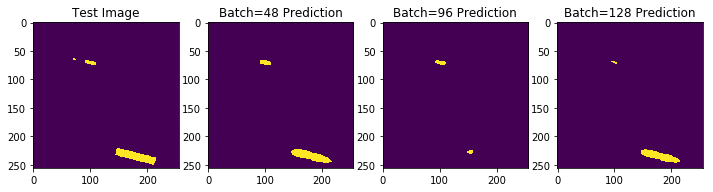

256


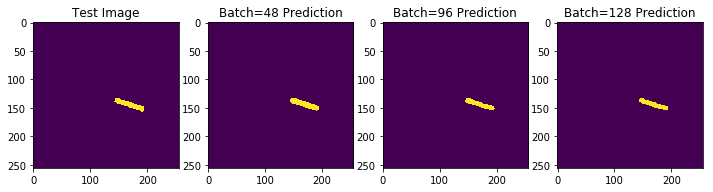

257


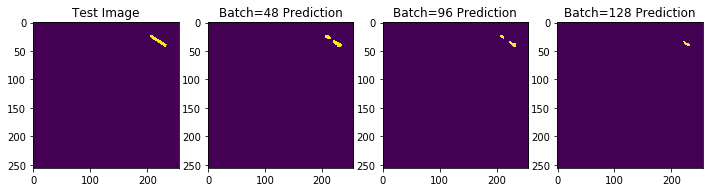

269


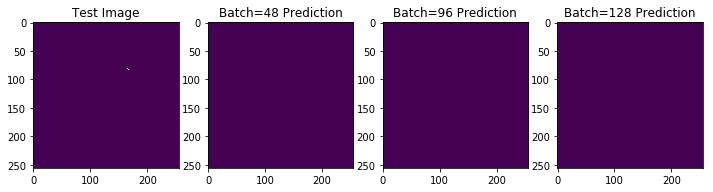

284


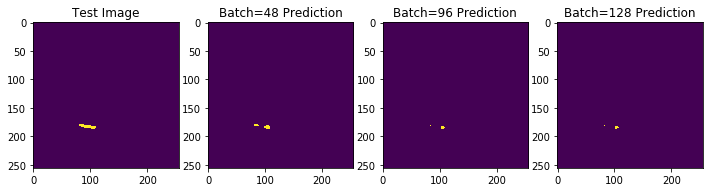

285


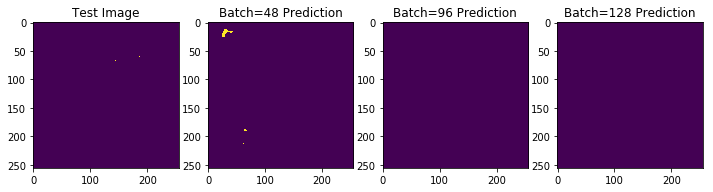

286


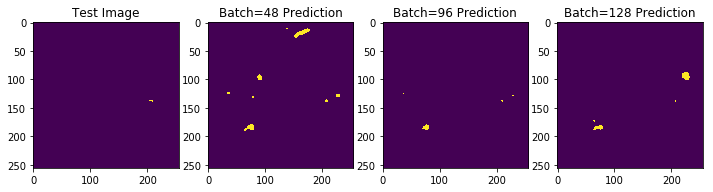

288


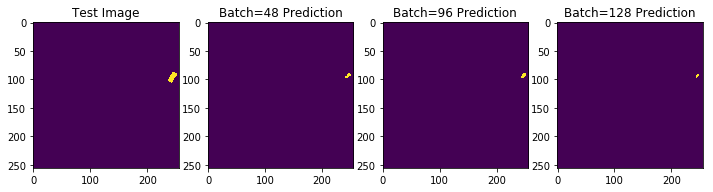

289


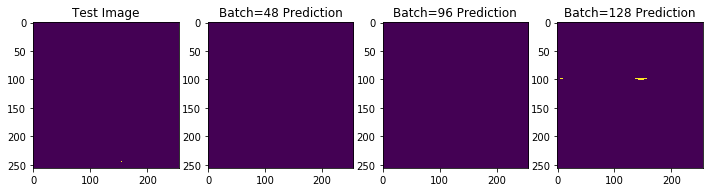

292


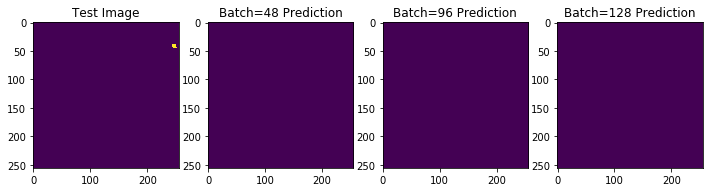

297


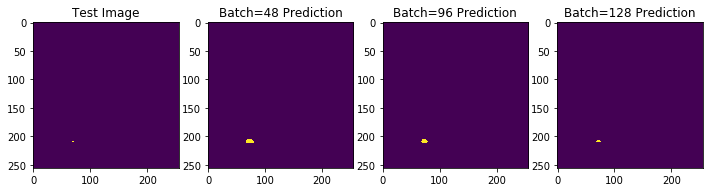

299


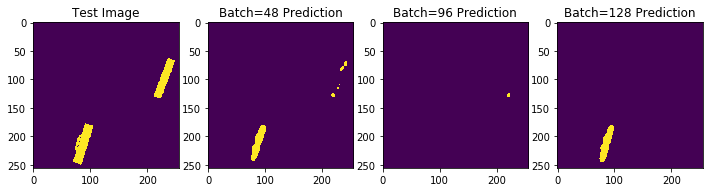

303


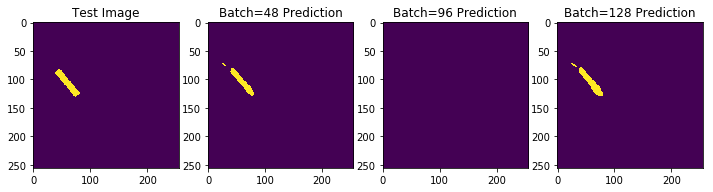

305


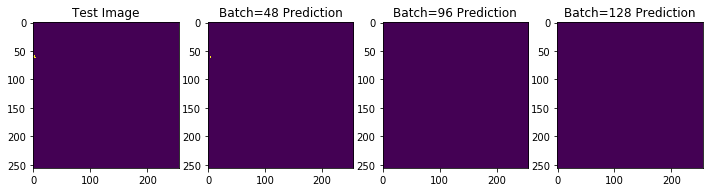

318


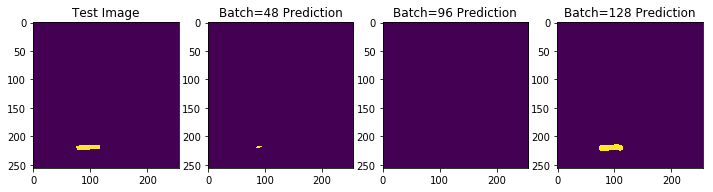

319


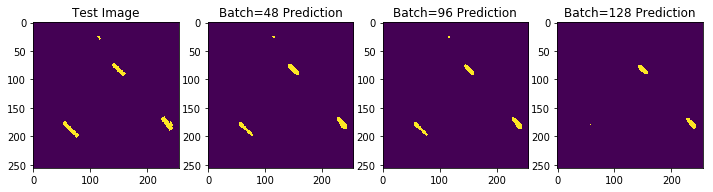

320


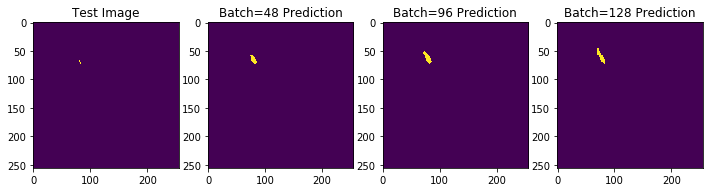

321


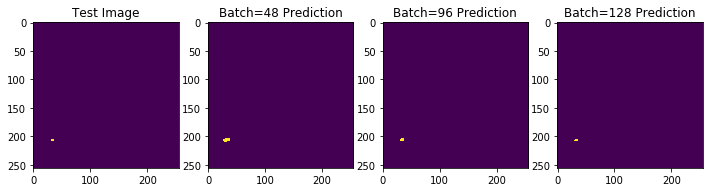

330


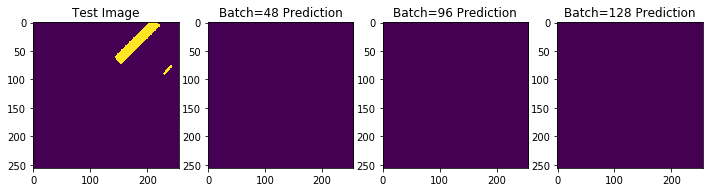

336


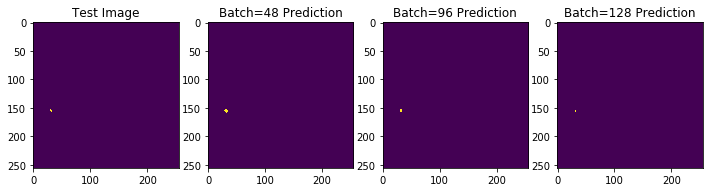

337


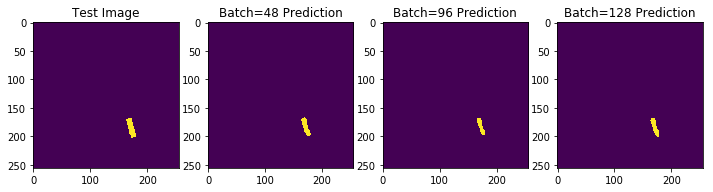

338


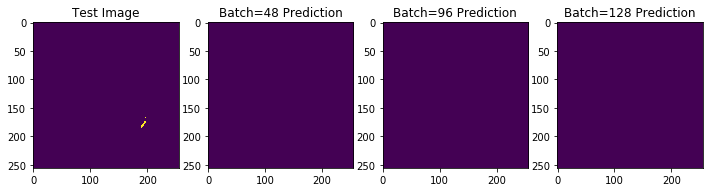

340


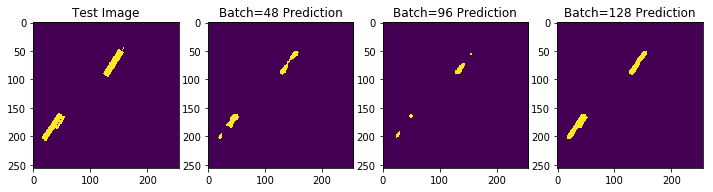

345


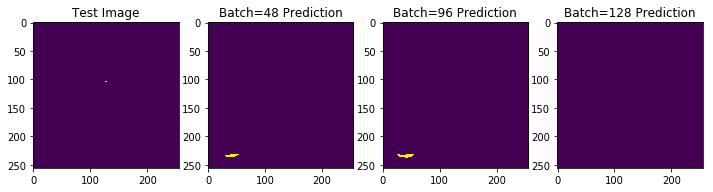

347


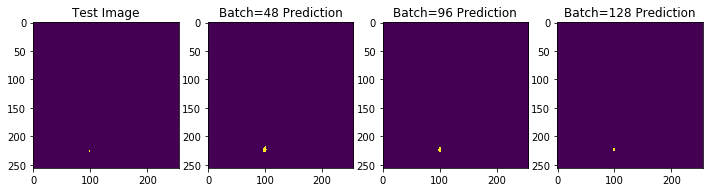

349


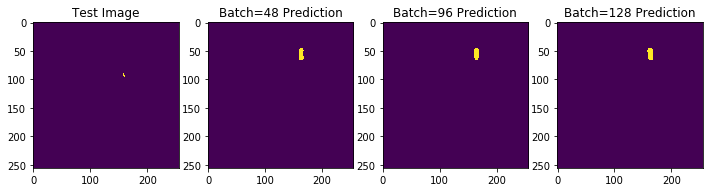

354


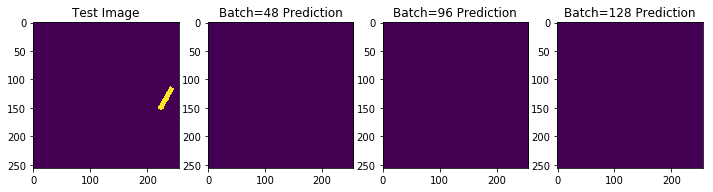

362


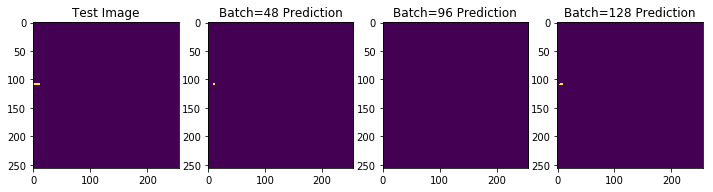

383


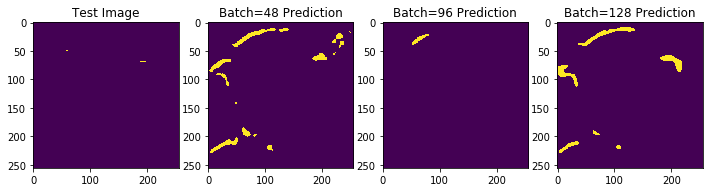

387


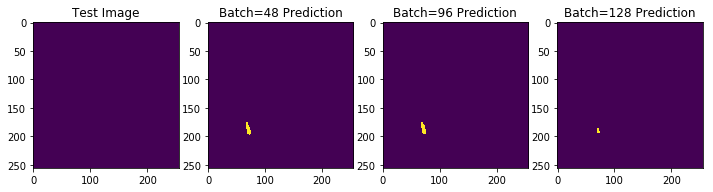

396


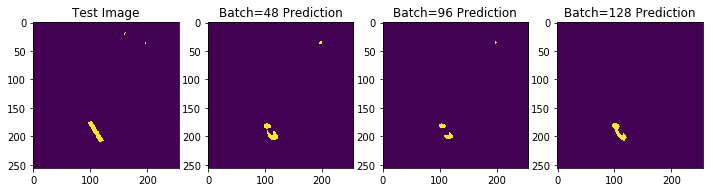

402


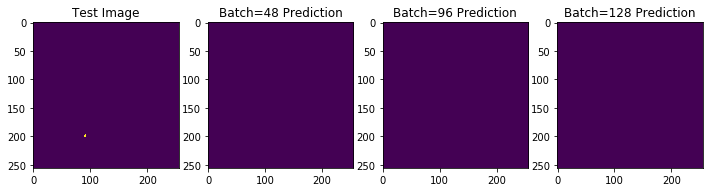

413


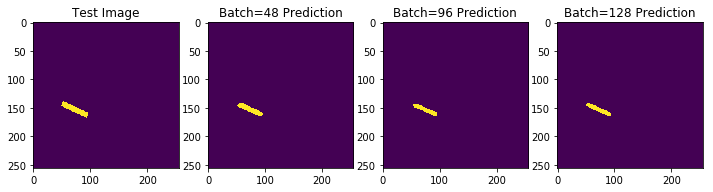

416


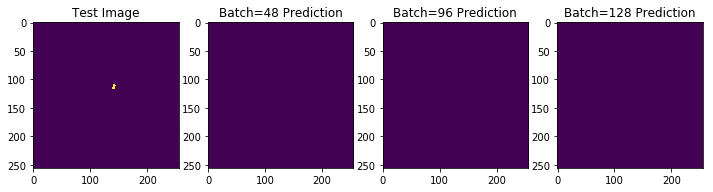

426


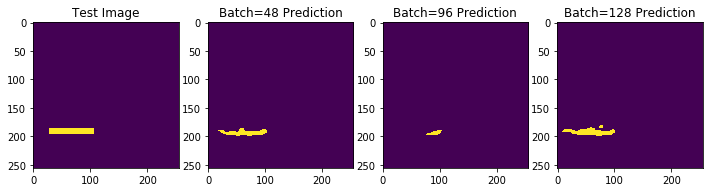

429


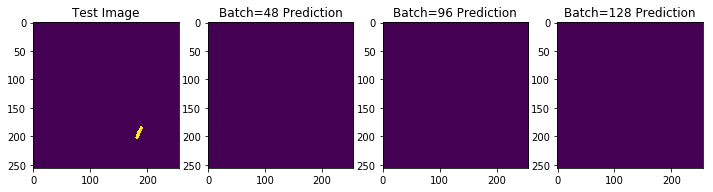

431


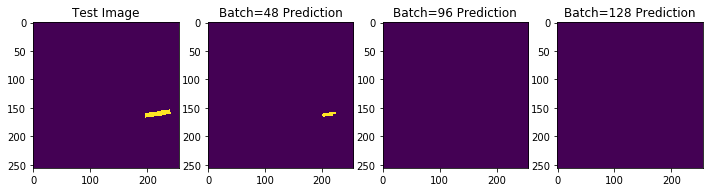

435


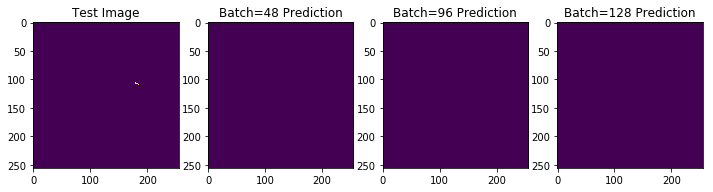

437


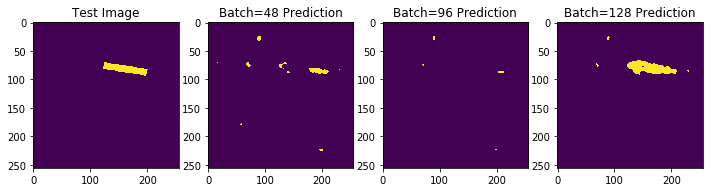

438


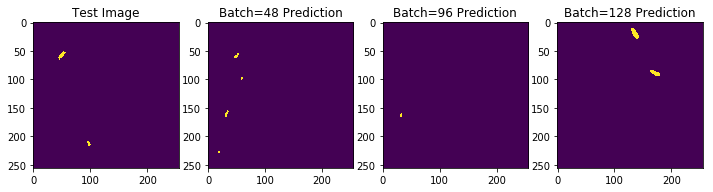

439


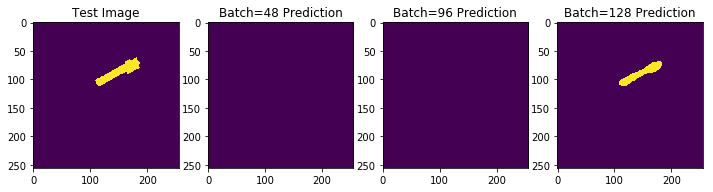

442


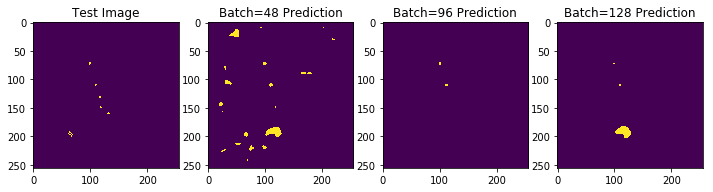

444


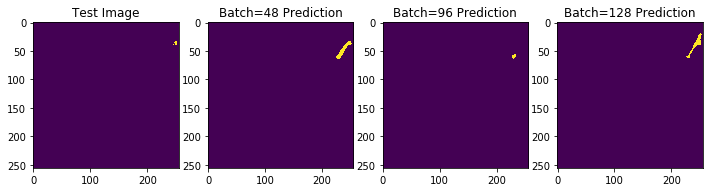

446


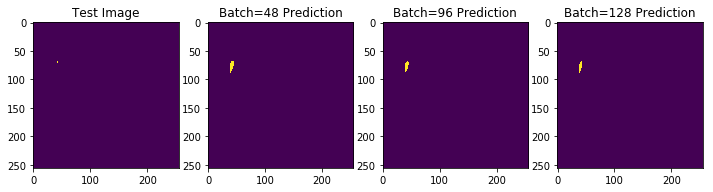

449


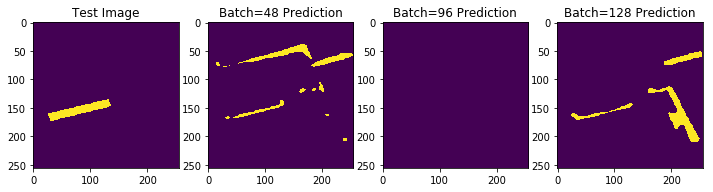

456


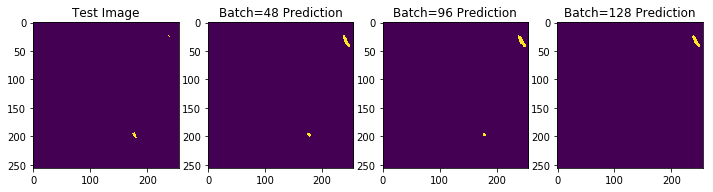

465


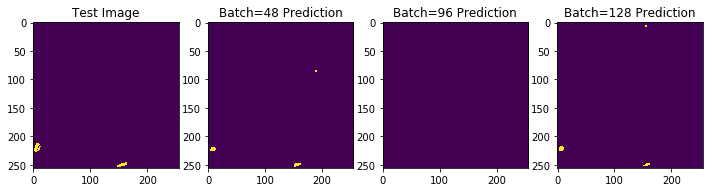

472


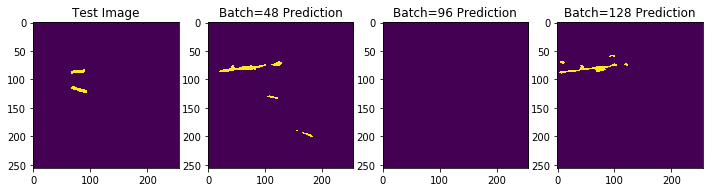

474


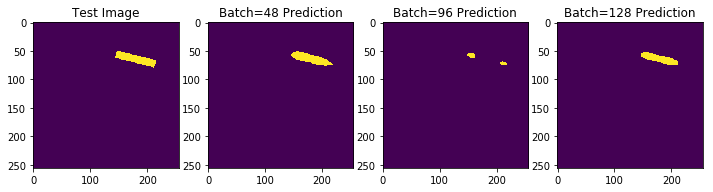

480


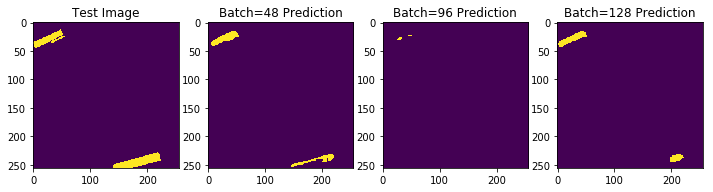

486


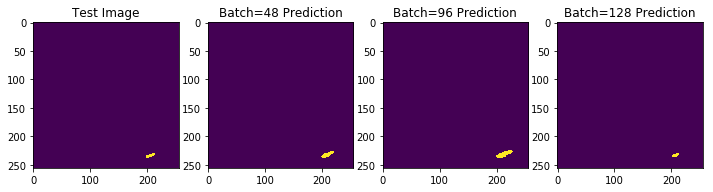

489


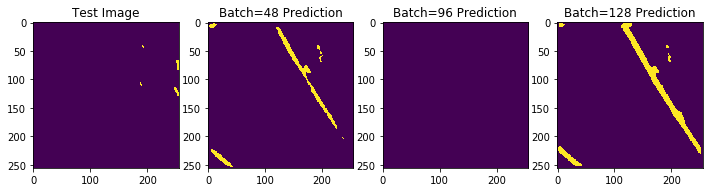

498


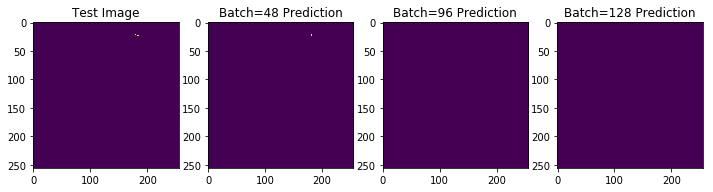

499


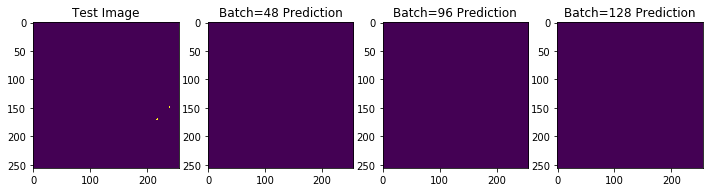

501


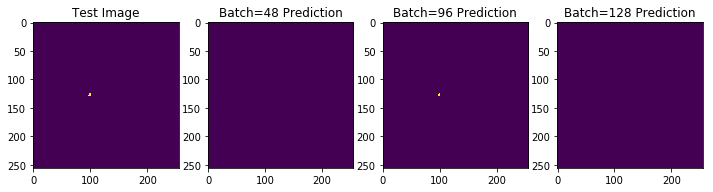

506


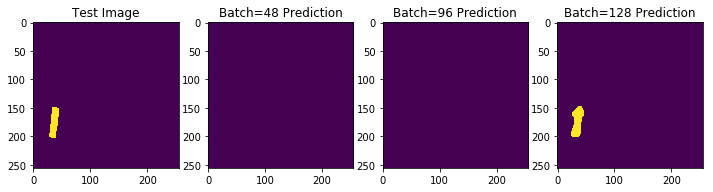

513


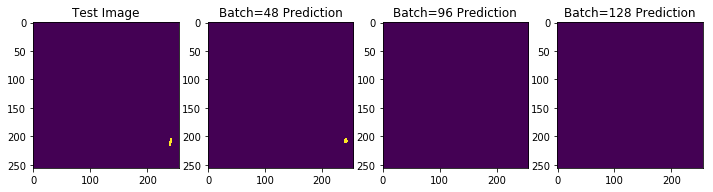

517


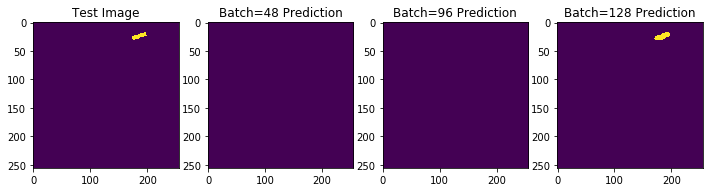

523


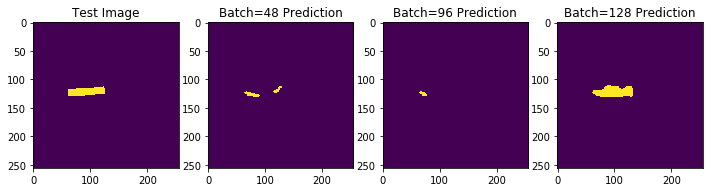

524


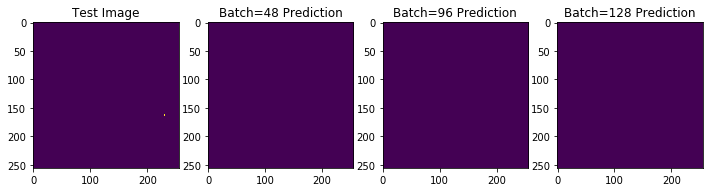

536


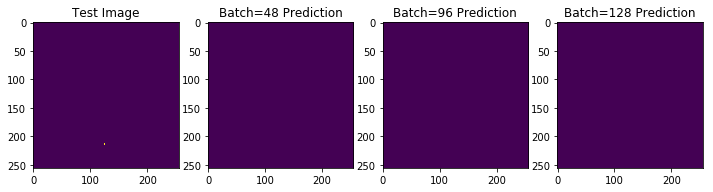

546


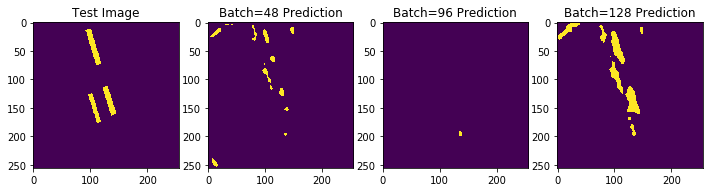

547


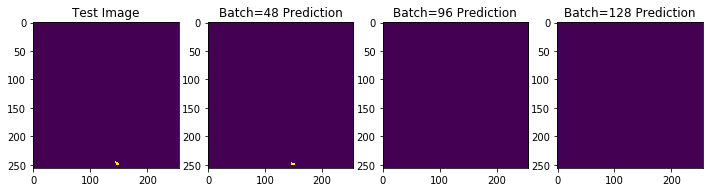

551


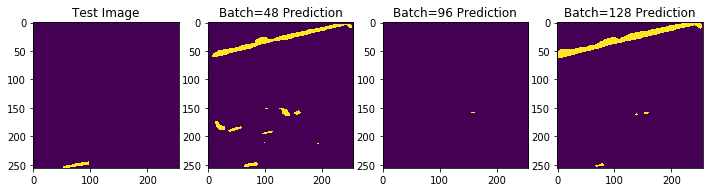

557


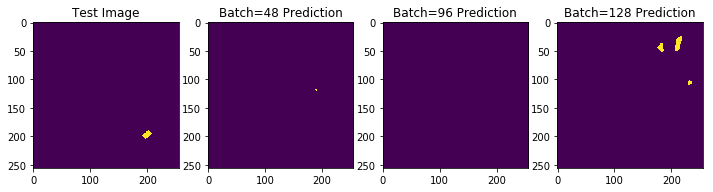

558


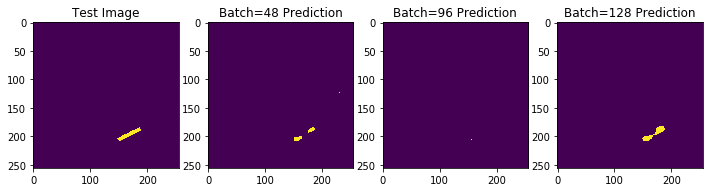

560


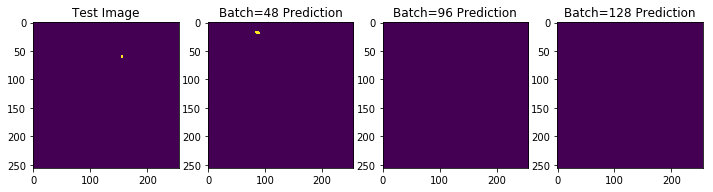

561


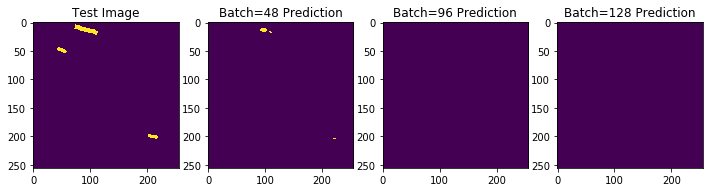

562


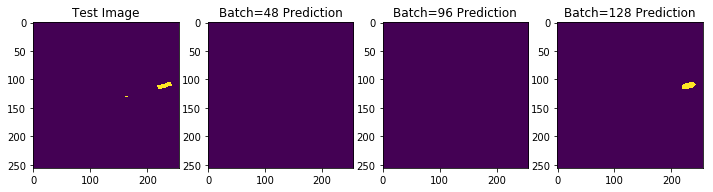

564


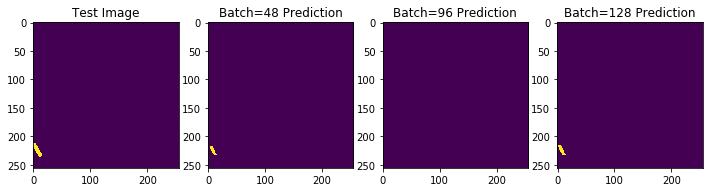

567


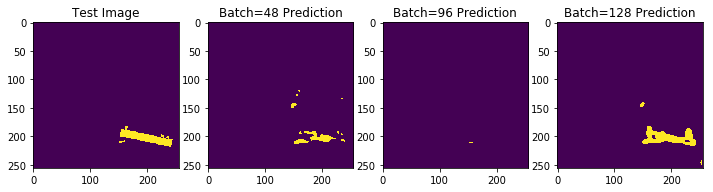

569


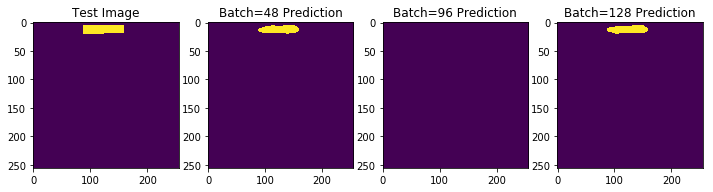

586


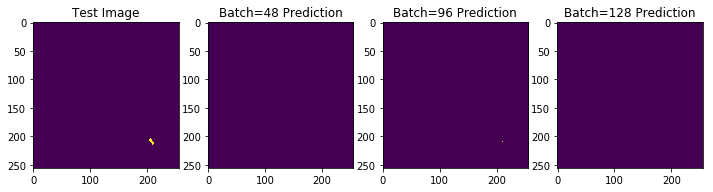

596


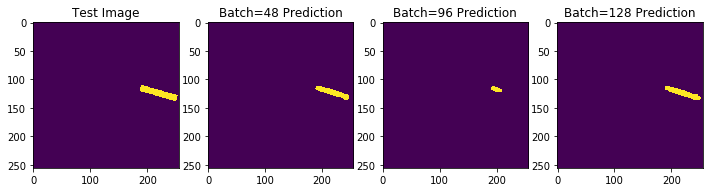

603


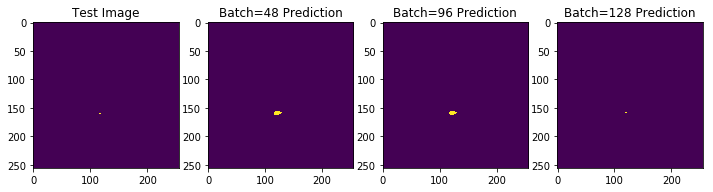

605


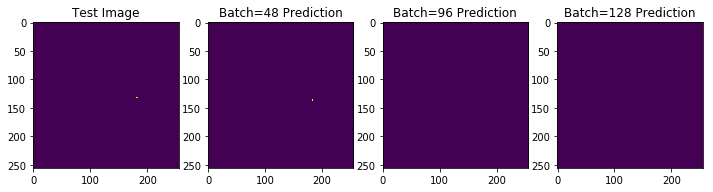

608


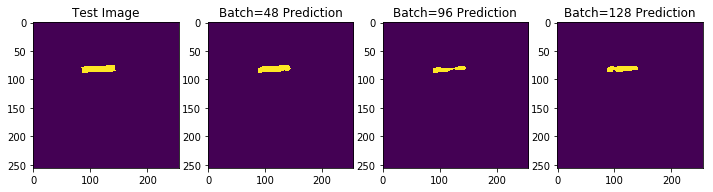

610


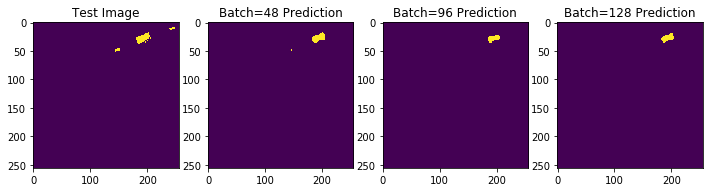

611


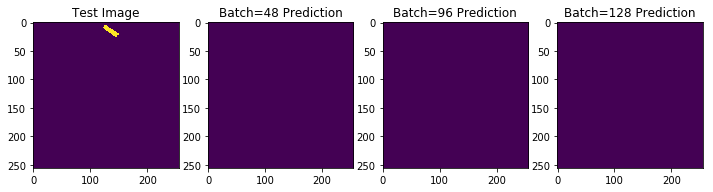

616


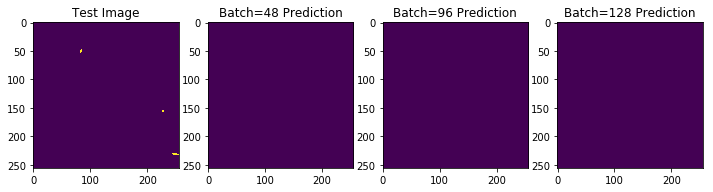

618


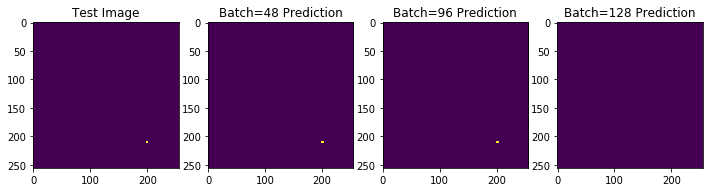

622


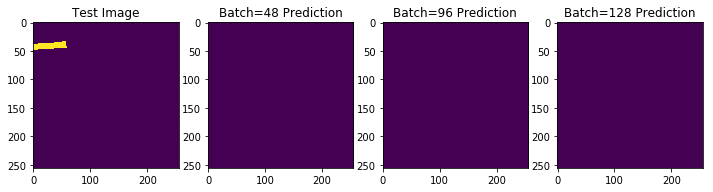

625


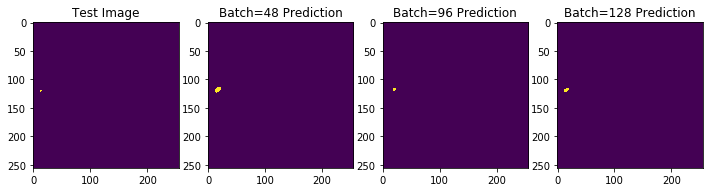

626


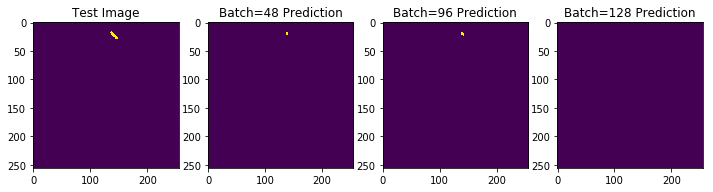

627


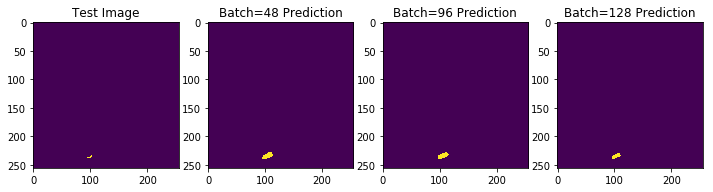

628


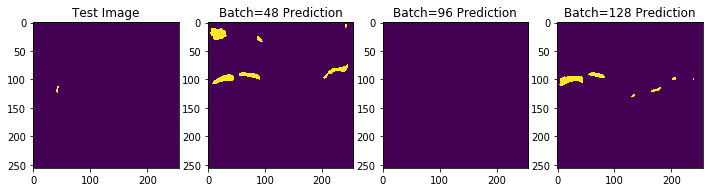

633


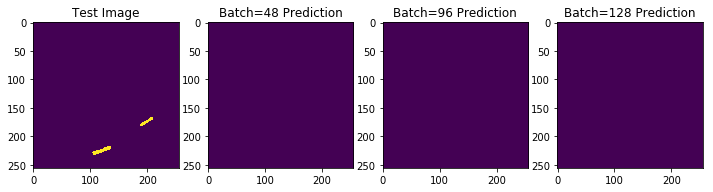

646


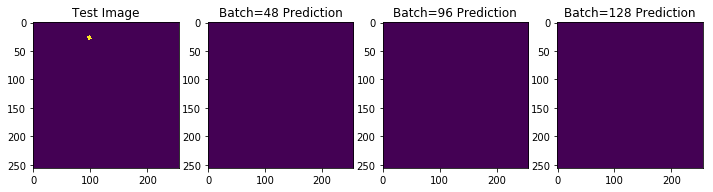

658


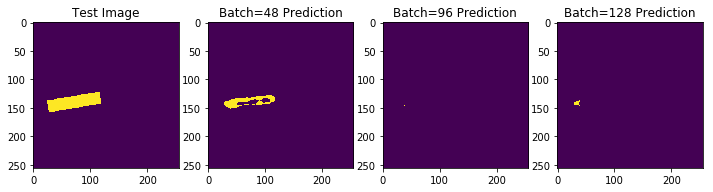

664


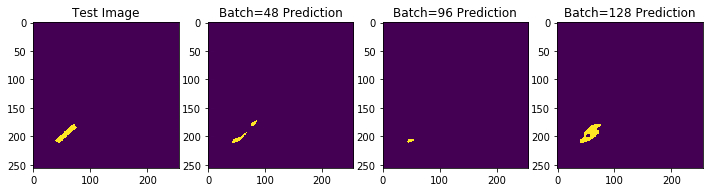

667


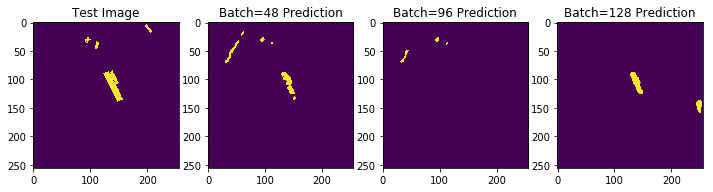

684


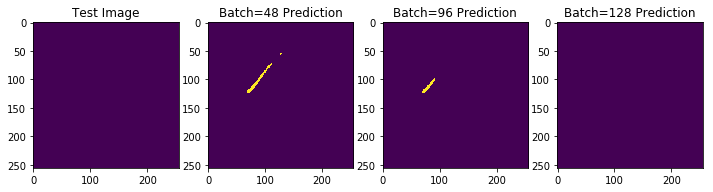

686


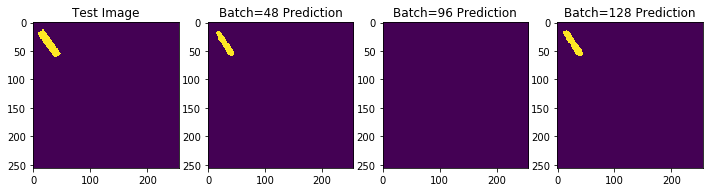

689


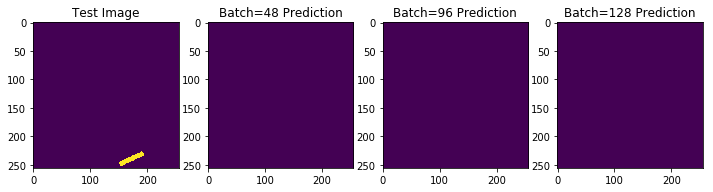

692


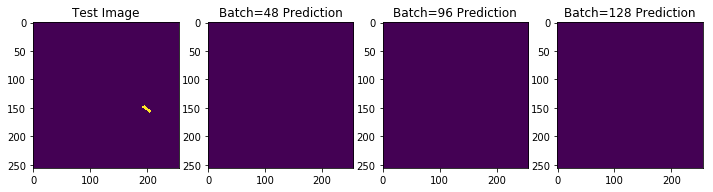

693


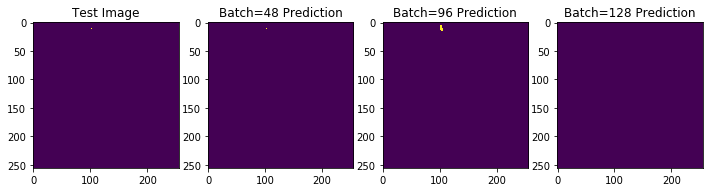

697


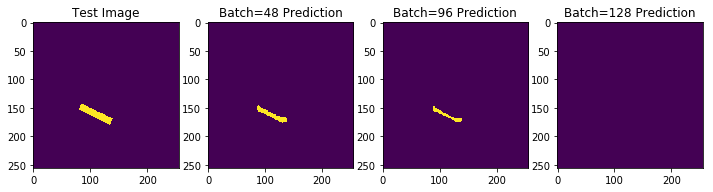

705


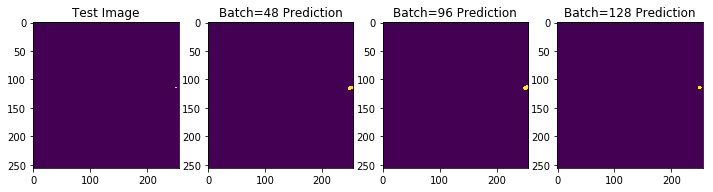

715


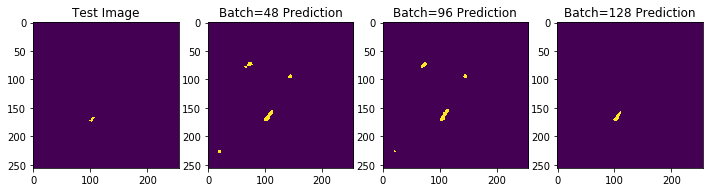

719


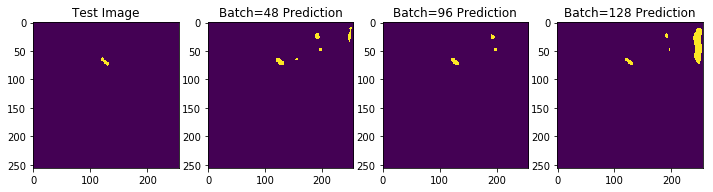

723


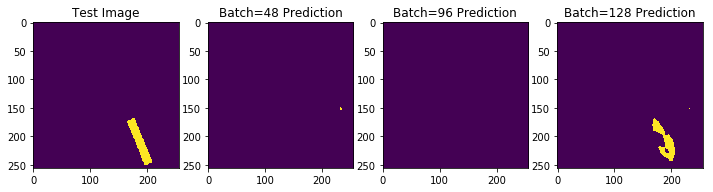

725


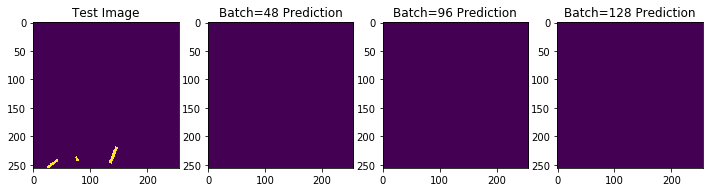

726


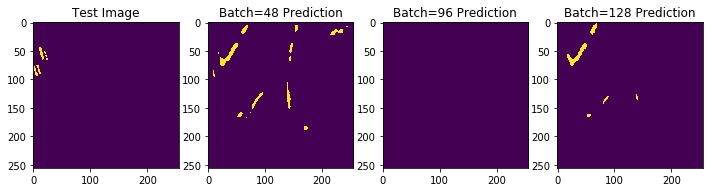

734


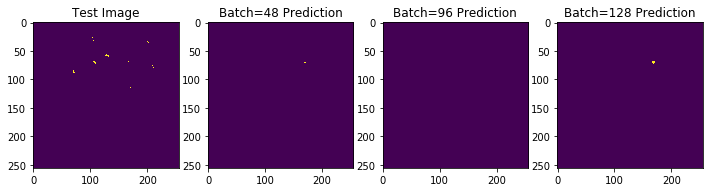

738


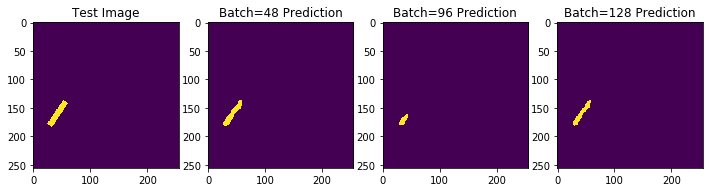

747


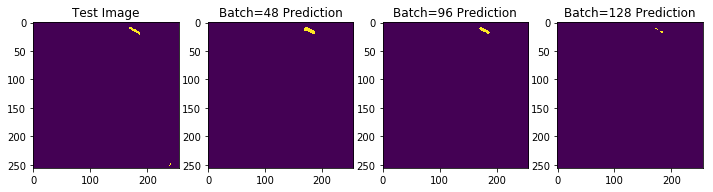

751


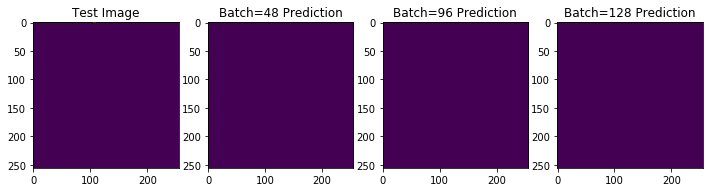

753


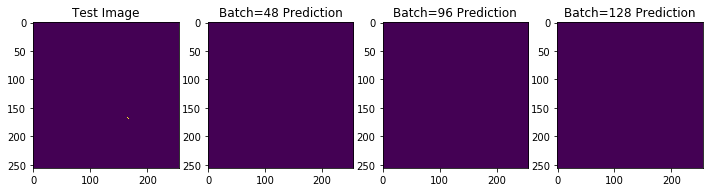

755


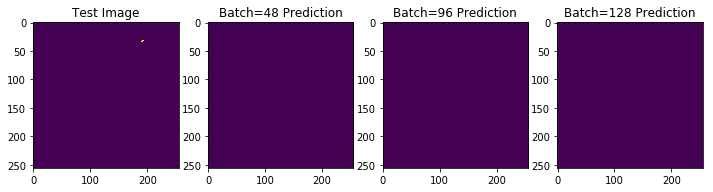

762


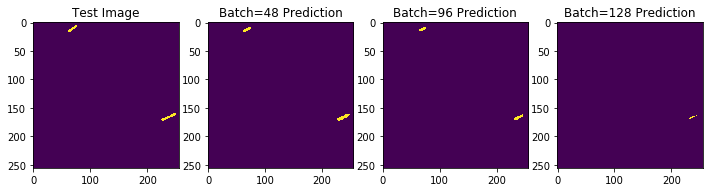

770


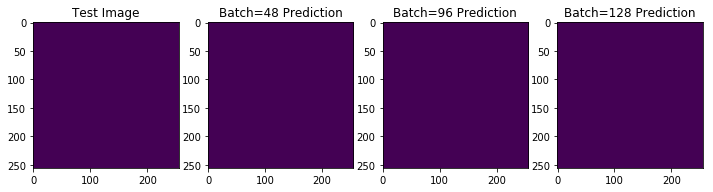

773


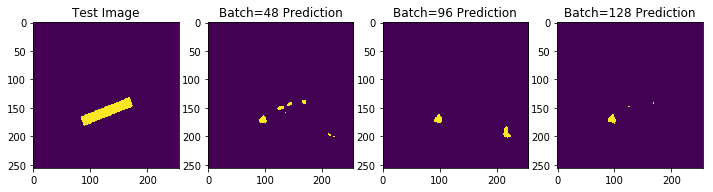

775


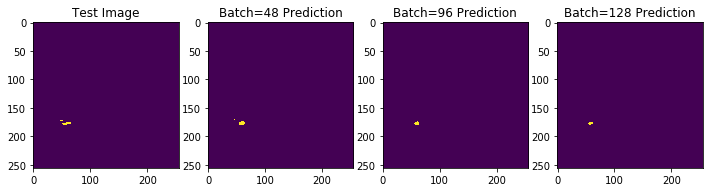

781


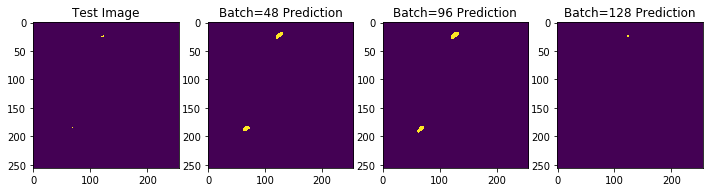

782


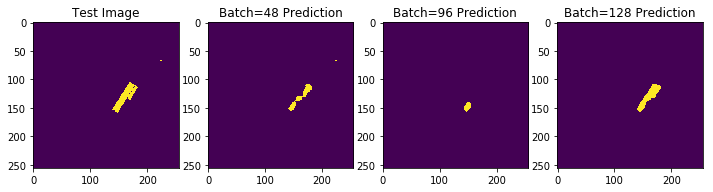

786


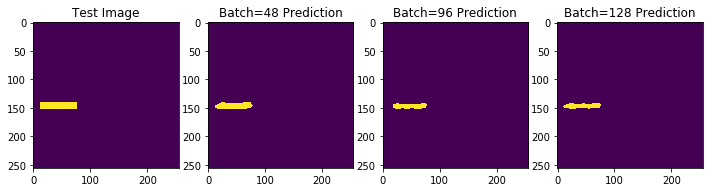

789


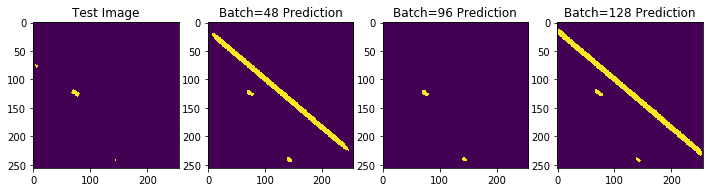

806


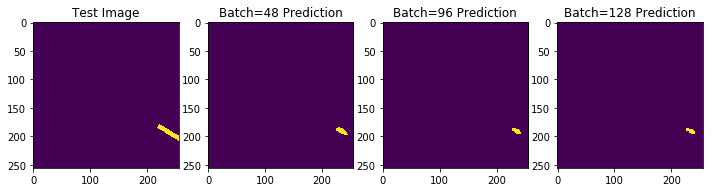

812


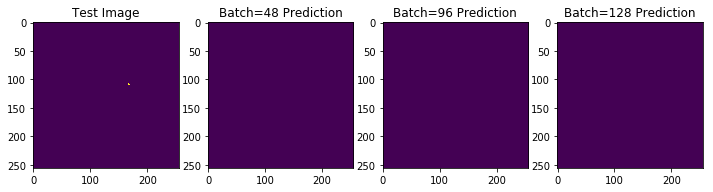

820


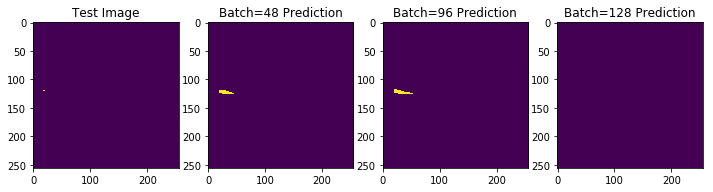

823


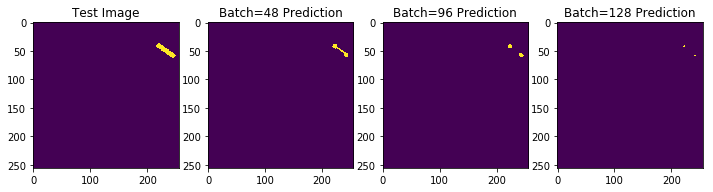

833


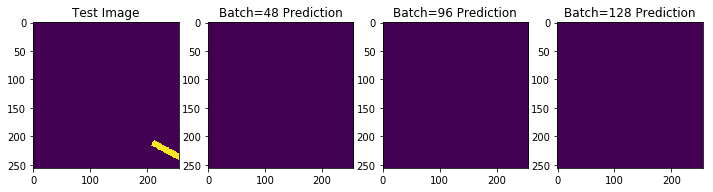

839


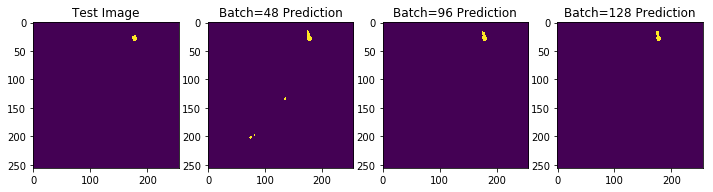

842


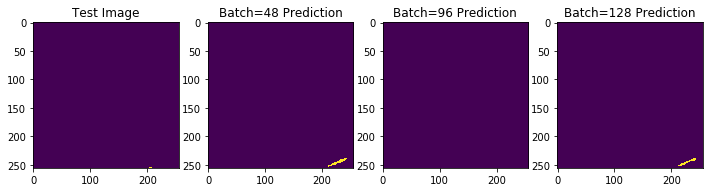

850


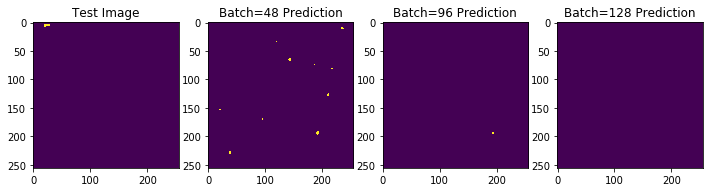

852


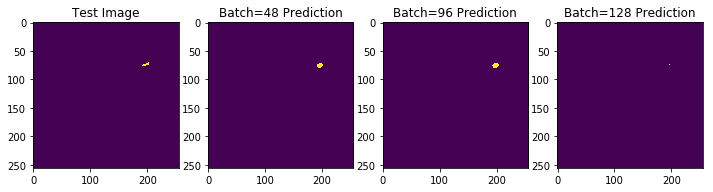

856


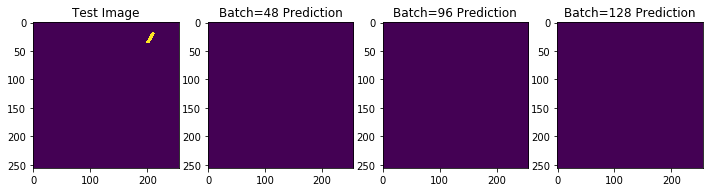

860


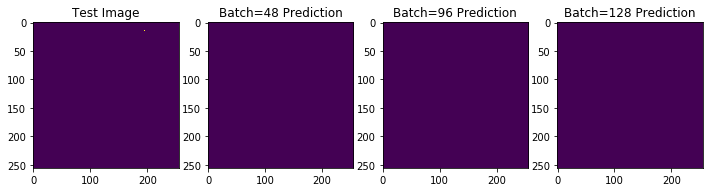

869


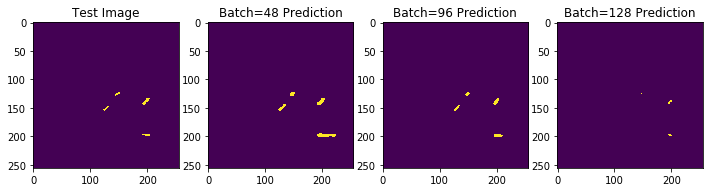

870


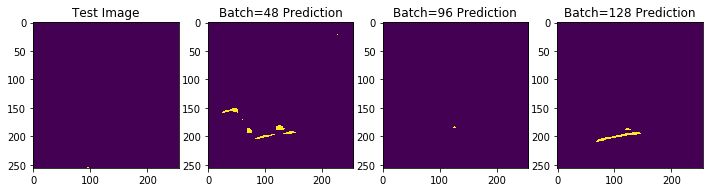

871


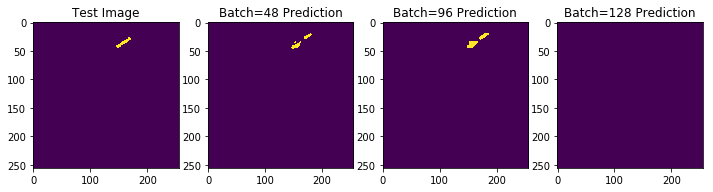

884


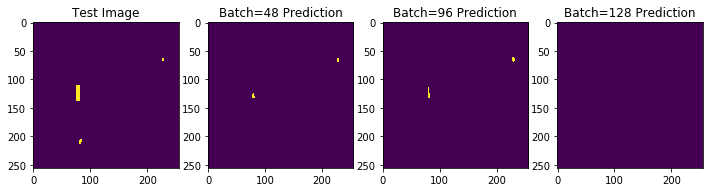

886


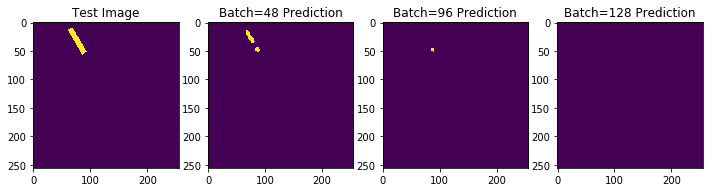

889


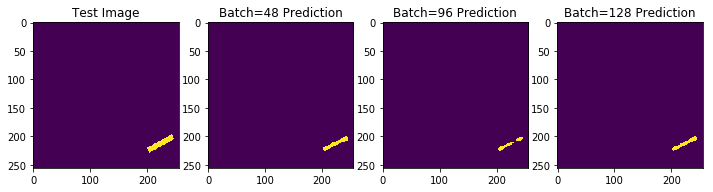

893


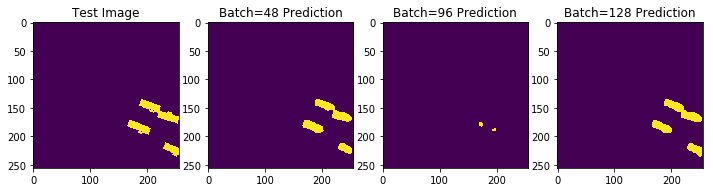

895


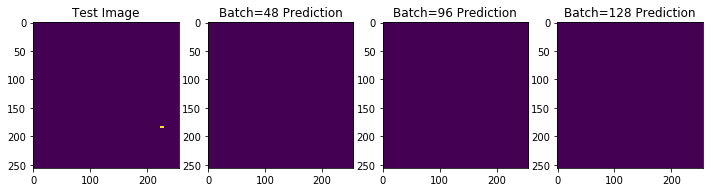

896


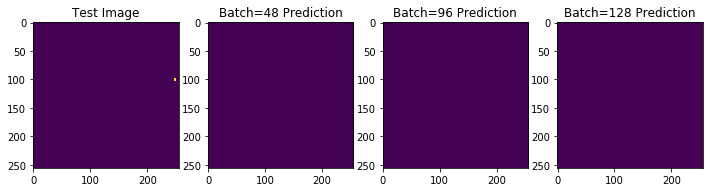

899


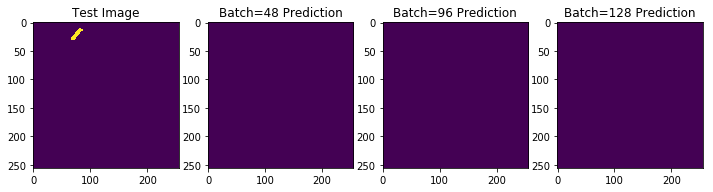

In [78]:
img_idx = 51
for img_idx in non_empty_idx:
    print(img_idx)
#     eps=1e-6

#     inter = np.sum(test_y[4] * pred_y_int[4])
#     uni = np.sum(test_y[4]) + np.sum(pred_y_int[4]) - inter
    
#     print((inter + eps) / (uni+eps))
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (12, 3))

    ax1.imshow(test_y[img_idx][:,:,0])
    ax1.set_title('Test Image')

    ax2.imshow(pred_y_48[img_idx][:,:,0])
    ax2.set_title('Batch=48 Prediction')
    
    ax3.imshow(pred_y_int_96[img_idx][:,:,0])
    ax3.set_title('Batch=96 Prediction')

    ax4.imshow(pred_y_int_128[img_idx][:,:,0])
    ax4.set_title('Batch=128 Prediction')

    plt.show()